In [1]:

import os.path as osp
shared_folder = osp.abspath(osp.join('..', '..', 'share'))
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join('..', 'data')),
    saves_folder_path=osp.abspath(osp.join('..', 'saves'))
)

# Import needed libraries
%pprint
sys.path.insert(1, '../py')
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from matplotlib.patches import Rectangle

Pretty printing has been turned OFF


In [2]:

generations_df = nu.load_object('generations_df')
turning_numbers_df = nu.load_object('turning_numbers_df')
turnings_df = nu.load_object('turnings_df')

In [3]:

if nu.pickle_exists('supreme_leaders_df'):
    supreme_leaders_df = nu.load_object('supreme_leaders_df')
else:
    tables_url = 'https://en.wikipedia.org/wiki/Supreme_Leader_(North_Korean_title)'
    df_list = nu.get_wiki_tables(tables_url)

    supreme_leaders_df = df_list[0].copy()
    mask_series = (supreme_leaders_df['Title(s)'] == supreme_leaders_df.groupby('Title(s)').size().sort_values().tail(1).index.item())
    supreme_leaders_df = supreme_leaders_df[mask_series].dropna(axis='columns', how='all').reset_index(drop=True)
    supreme_leaders_df['leader_name'] = supreme_leaders_df.Name.map(lambda x: str(x).split('김')[0].strip())
    supreme_leaders_df['year_of_birth'] = supreme_leaders_df.Name.map(lambda x: int(re.split(r'\D+', str(x), 0)[1]))
    supreme_leaders_df['year_of_death'] = supreme_leaders_df.Name.map(lambda x: re.split(r'\D+', str(x), 0)[-2].strip().replace('1982', ''))
    supreme_leaders_df['office_rank'] = supreme_leaders_df.index.map(lambda x: x+1)
    supreme_leaders_df['year_term_begin'] = supreme_leaders_df.Tenure.map(lambda x: str(x).split('–')[0].strip().split(' ')[-1].strip())
    for cn in ['year_of_birth', 'year_of_death', 'office_rank', 'year_term_begin']:
        supreme_leaders_df[cn] = pd.to_numeric(supreme_leaders_df[cn], errors='coerce')
    for row_index, row_series in supreme_leaders_df.iterrows():
        year_of_birth = row_series.year_of_birth
        mask_series = (generations_df.birth_year_begin <= year_of_birth) & (generations_df.birth_year_end >= year_of_birth)
        generation_name = generations_df[mask_series].index.item()
        supreme_leaders_df.loc[row_index, 'generation_name'] = generation_name
        turnings_archetype = generations_df[mask_series].turnings_archetype.squeeze()
        supreme_leaders_df.loc[row_index, 'turnings_archetype'] = turnings_archetype
    for row_index, row_series in supreme_leaders_df.iterrows():
        year_term_begin = row_series.year_term_begin
        mask_series = (turnings_df.turning_year_begin <= year_term_begin) & (turnings_df.turning_year_end >= year_term_begin)

        # Get turning number
        turning_number = turnings_df[mask_series].turning_number.squeeze()
        supreme_leaders_df.loc[row_index, 'turning_number'] = turning_number

        # Get turning name
        turning_name = turnings_df[mask_series].index.item()
        supreme_leaders_df.loc[row_index, 'turning_name'] = turning_name

        # Get turning type
        mask_series = (turning_numbers_df.index == turning_number)
        turning_type = turning_numbers_df[mask_series].turning_type.squeeze()
        supreme_leaders_df.loc[row_index, 'turning_type'] = turning_type

    supreme_leaders_df.turning_number = supreme_leaders_df.turning_number.astype(int)
    supreme_leaders_df['age_at_inauguration'] = (supreme_leaders_df.year_term_begin - supreme_leaders_df.year_of_birth)
    supreme_leaders_df = supreme_leaders_df.set_index('leader_name')
    
    nu.store_objects(supreme_leaders_df=supreme_leaders_df)

In [4]:

supreme_leaders_df.T

leader_name,Kim Il Sung,Kim Jong Il,Kim Jong Un
Name,Kim Il Sung 김일성 (1912–1994),Kim Jong Il 김정일 (1941–2011),Kim Jong Un 김정은 (born 1982)
Title(s),General Secretary of the WPK,General Secretary of the WPK,General Secretary of the WPK
Period,12 October 1966 – 8 July 1994,8 October 1997 – 17 December 2011,10 January 2021 – present
Tenure,9 September 1948 – 8 July 1994,9 April 1994 – 17 December 2011,11 April 2012 – present
Ideological contribution(s),Juche,Kimilsungism Songun Ten Principles,Kimilsungism–Kimjongilism Byungjin
year_of_birth,1912,1941,1982
year_of_death,1994.0,2011.0,NaN
office_rank,1,2,3
year_term_begin,1948,1994,2012
generation_name,G.I.,Silent,Millennial


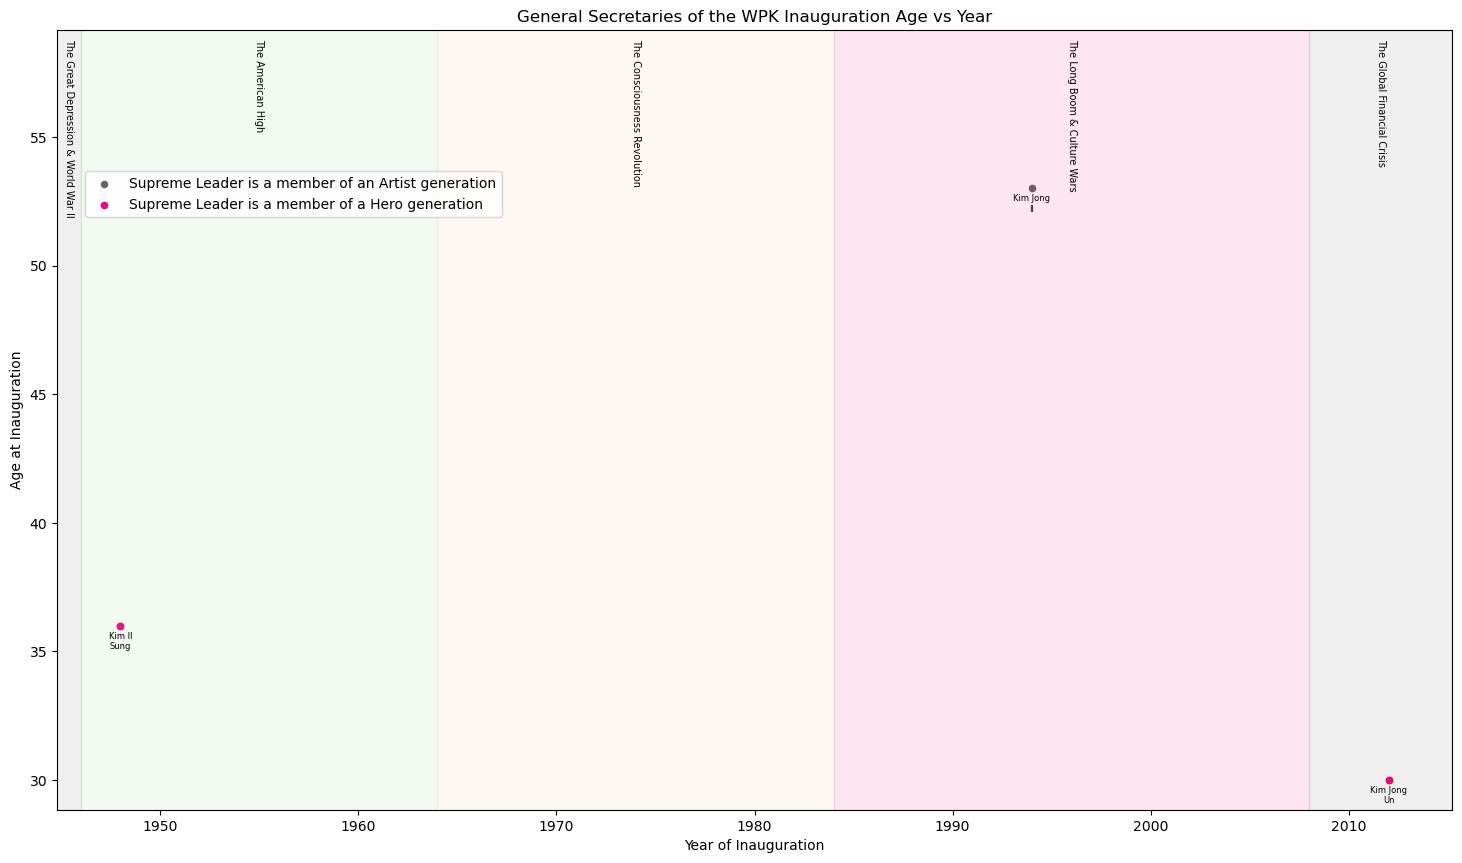

In [5]:

df1 = turnings_df.reset_index()
df2 = generations_df.reset_index()
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
nu.plot_inauguration_age(
    inauguration_df=supreme_leaders_df, groupby_column_name='turnings_archetype', xname='year_term_begin', leader_designation='Supreme Leader',
    label_infix='is a member of', label_suffix='generation', info_df=df3,
    title_prefix='General Secretaries of the WPK'
)

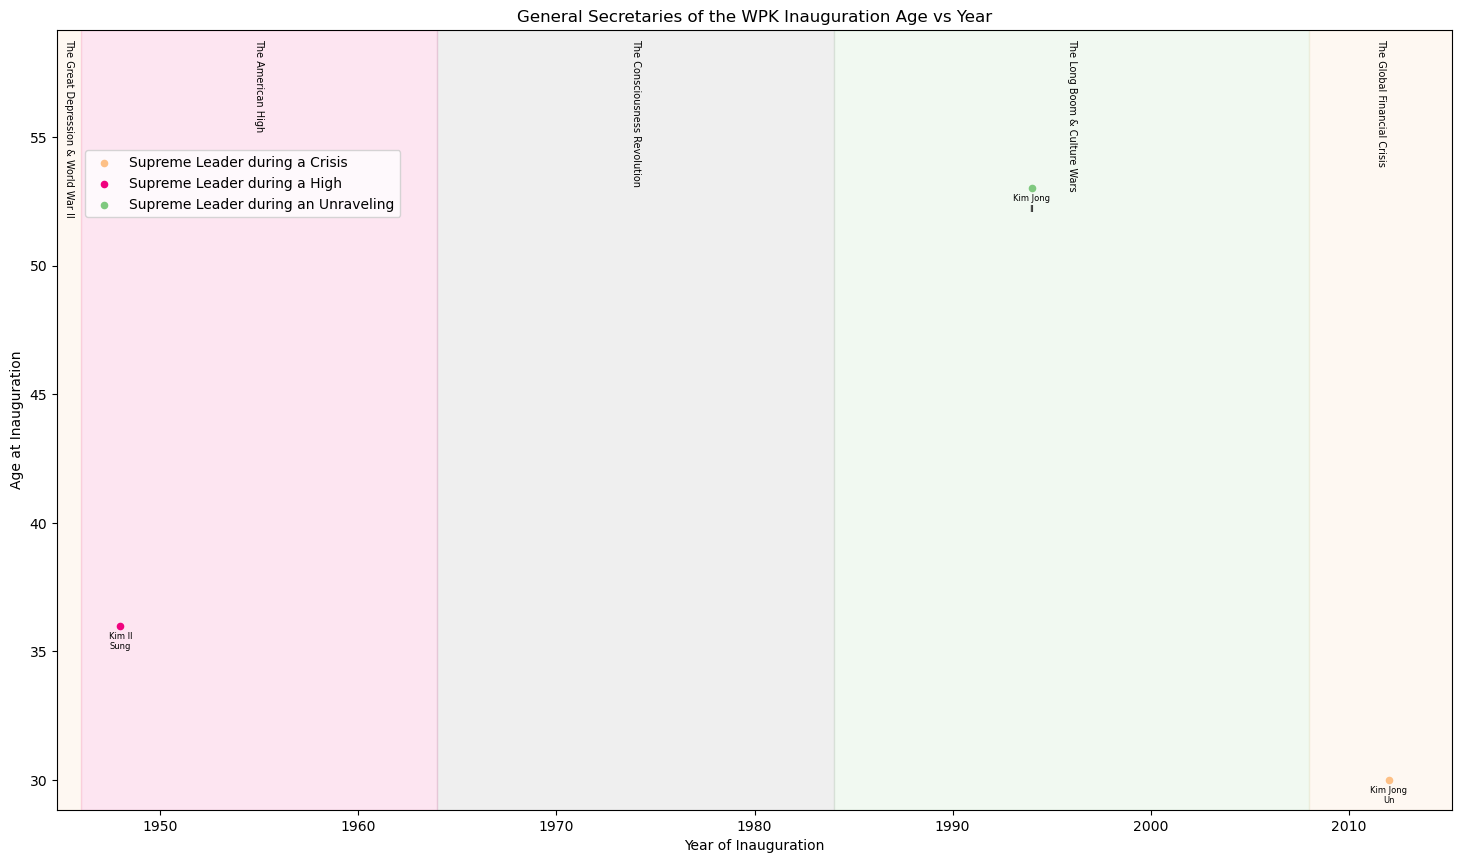

In [6]:

df1 = turnings_df.reset_index()
df2 = turning_numbers_df.reset_index().rename(columns={'index': 'turning_number'})
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
df4 = generations_df.reset_index()
on_list = list(set(df3.columns).intersection(set(df4.columns)))
df5 = df3.merge(df4, on=on_list)
nu.plot_inauguration_age(
    inauguration_df=supreme_leaders_df, groupby_column_name='turning_type', xname='year_term_begin', leader_designation='Supreme Leader',
    label_infix='during', label_suffix='', info_df=df5,
    title_prefix='General Secretaries of the WPK'
)


# Maintenance

In [95]:

df1 = turnings_df.reset_index()
df2 = turning_numbers_df.reset_index().rename(columns={'index': 'turning_number'})
on_list = list(set(df1.columns).intersection(set(df2.columns)))
df3 = df1.merge(df2, on=on_list)
df4 = generations_df.reset_index()
on_list = list(set(df3.columns).intersection(set(df4.columns)))
if on_list:
    # display(df1.tail(4).T)
    # display(df2.tail(5).T)
    print(on_list)
    display(df3.merge(df4, on=on_list).sample(5).T)

['saeculum_name', 'turning_year_end', 'turning_year_begin']


,15,6,19,2,5
turning_name,The Puritan Awakening,American Revolution,The Consciousness Revolution,The Mexican War & Sectionalism,The colonial Glorious Revolution
turning_number,2,4,2,3,4
turning_year_begin,1621,1773,1964,1844,1675
turning_year_end,1649,1794,1984,1860,1704
saeculum_name,New World,Revolutionary,Millennial,Civil War,New World
entering_elderhood,Elizabethans,Awakeners,G.I.s,Compromisers,Puritans
entering_midlife,Parliamentarians,Liberty,Silent,Transcendentals,Cavaliers
entering_young_adulthood,Puritans,Republicans,Boomers,Gilded,Glorious
entering_childhood,Cavaliers,Compromisers,Xers,Progressives,Enlighteners
turning_notes,"The Puritan Awakening (Second Turning, 1621–16...","American Revolution (Fourth Turning, 1773–1794...","The Consciousness Revolution (Second Turning, ...","The Mexican War & Sectionalism (Third Turning,...",The colonial Glorious Revolution (Fourth Turni...


In [60]:

columns_list = ['turning_year_begin', 'turning_year_end', 'turnings_archetype', 'turning_name']
df1 = turnings_df.reset_index()
display(df1.tail().T)
df2 = generations_df.reset_index()
display(df2[list(set(columns_list).intersection(set(df2.columns)))].tail())
df1.merge(
    df2, on=list(set(df1.columns).intersection(set(df2.columns)))
)[columns_list].tail()

,21,22,23,24,25
turning_name,The Great Depression & World War II,The American High,The Consciousness Revolution,The Long Boom & Culture Wars,The Global Financial Crisis
turning_number,4,1,2,3,4
turning_year_begin,1929,1946,1964,1984,2008
turning_year_end,1946,1964,1984,2008,2029
saeculum_name,Great Power,Millennial,Millennial,Millennial,Millennial
entering_elderhood,Missionaries,Lost,G.I.s,Silent,Boomers
entering_midlife,Lost,G.I.s,Silent,Boomers,Xers
entering_young_adulthood,G.I.s,Silent,Boomers,Xers,Millennials
entering_childhood,Silent,Boomers,Xers,Millennials,Homelanders
turning_notes,The Great Depression & World War II (Fourth Tu...,"The American High (First Turning, 1946–1964) w...","The Consciousness Revolution (Second Turning, ...","The Long Boom & Culture Wars (Third Turning, 1...","The Global Financial Crisis (Fourth Turning, 2..."


,turnings_archetype,turning_year_end,turning_year_begin
22,Prophet,1964.0,1946
23,Nomad,1984.0,1964
24,Hero,2008.0,1984
25,Artist,2029.0,2008
26,Prophet,2045.0,2029


,turning_year_begin,turning_year_end,turnings_archetype,turning_name
15,1929,1946,Artist,The Great Depression & World War II
16,1946,1964,Prophet,The American High
17,1964,1984,Nomad,The Consciousness Revolution
18,1984,2008,Hero,The Long Boom & Culture Wars
19,2008,2029,Artist,The Global Financial Crisis


In [34]:

mask_series = (generations_df.turning_year_begin == 2030)
generations_df.loc[mask_series, 'turning_year_begin'] = 2029
nu.store_objects(generations_df=generations_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\saves\pkl\generations_df.pkl



----

In [ ]:

from cycler import cycler
from storage import Storage
import numpy as np

In [ ]:

%run ../load_magic/storage.py
%run ../load_magic/dataframes.py
%run ../load_magic/lists.py
from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request
%who

In [ ]:

ages_list = df.sort_values('age_at_inauguration').age_at_inauguration.tolist()
assert len([item for sublist in nu.get_splits_list(ages_list) for item in sublist]) == len(ages_list)

In [ ]:

jitter_list = nu.get_jitter_list(ages_list)
assert len(jitter_list) == len(ages_list)

In [ ]:

df = check_for_typos(left_list=generations_df.index, right_list=turnings_df.entering_midlife, verbose=False)
mask_series = (df.max_similarity < 1.0)
for row_index, row_series in df[mask_series].sort_values('max_similarity', ascending=False).head(15).iterrows():
    left_item = row_series.left_item
    right_item = row_series.right_item
    exec(f"mask_series = (turnings_df.entering_midlife == '{right_item}')")
    exec(f"turnings_df.loc[mask_series, 'entering_midlife'] = '{left_item}'")

In [ ]:

mask_series = (turnings_df.entering_midlife == 'Xers')
turnings_df.loc[mask_series, 'entering_midlife'] = '13th'

In [ ]:

df = check_for_typos(left_list=generations_df.index, right_list=turnings_df.entering_midlife, verbose=False)
mask_series = (df.max_similarity < 1.0)
df[mask_series].sort_values('max_similarity', ascending=False)

In [ ]:

columns_list = ['turning_number', 'entering_midlife']
turnings_df[columns_list].reset_index().merge(
    generations_df.turnings_archetype.reset_index(), left_on='entering_midlife', right_on='generation_name'
)

In [108]:

face_color_dict

{'Nomad': array([0.4, 0.4, 0.4, 1. ]), 'Artist': array([0.99215686, 0.75294118, 0.5254902 , 1.        ]), 'Prophet': array([0.94117647, 0.00784314, 0.49803922, 1.        ])}

C:\Users\daveb\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
C:\Users\daveb\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1256: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
C:\Users\daveb\AppData\Roaming\Python\Python39\site-packages\pandas\plotting\_matplotl

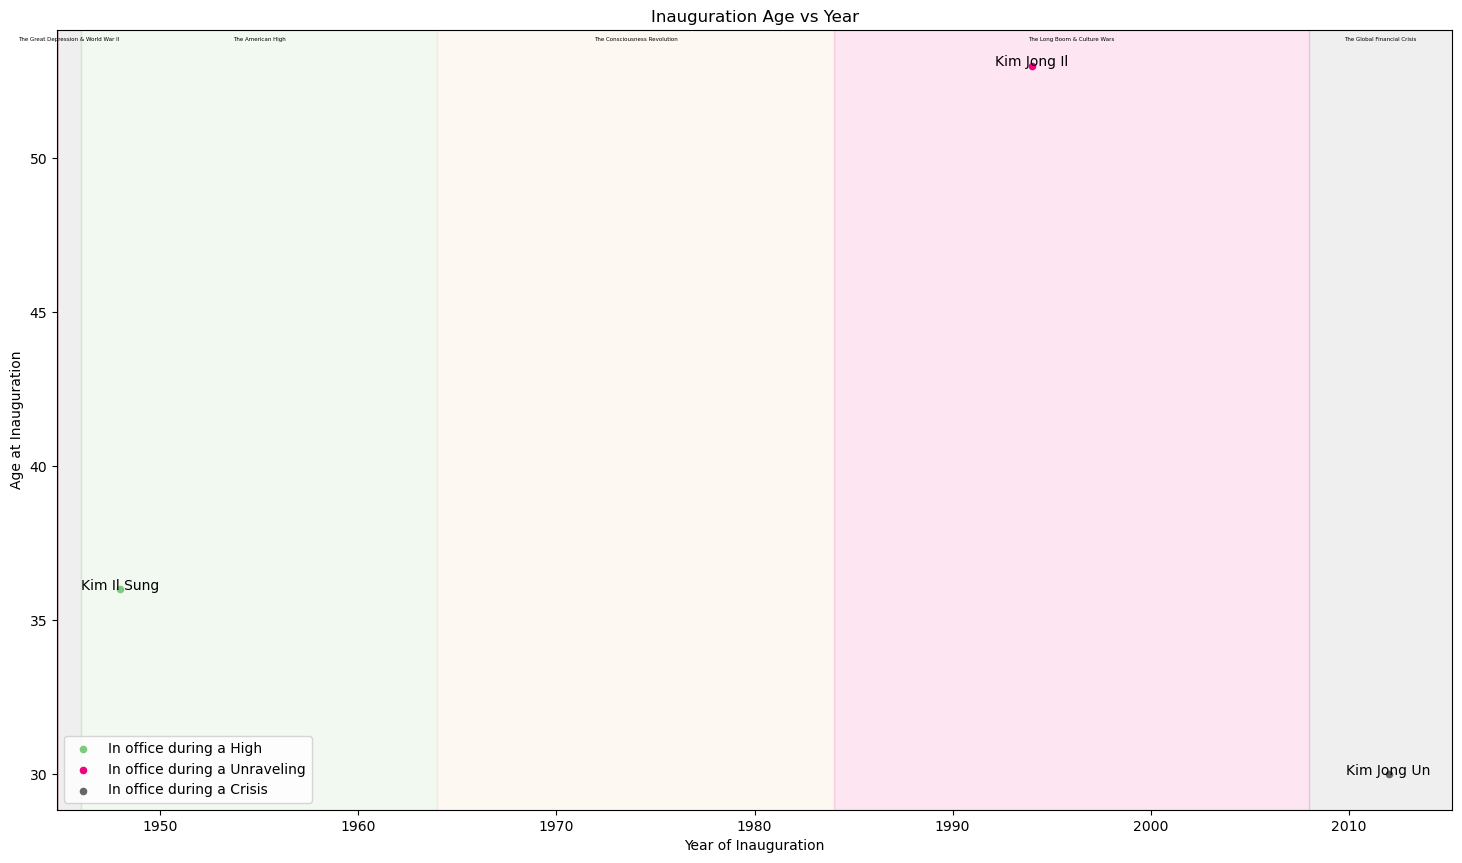

In [92]:

get_column_descriptions(supreme_leaders_df)

C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\load_magic\dataframes.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_series = pd.to_datetime(df[column_name], errors='coerce')
C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\load_magic\dataframes.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_series = pd.to_datetime(df[column_name], errors='coerce')
C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\load_magic\dataframes.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_series = pd.to_datetime(df[column_name], errors='coerce')
C

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
0,year_of_birth,int64,0,3,0,True,1912,1982,True
1,office_rank,int64,0,3,0,True,1,3,True
2,year_term_begin,int64,0,3,0,True,1948,2012,True
3,year_of_death,float64,1,3,0,True,1994.0,2011.0,False
4,turning_number,float64,0,3,0,True,1.0,4.0,True
5,Name,object,0,3,0,False,Kim Il Sung 김일성 (1912–1994),Kim Jong Un 김정은 (born 1982),NaN
6,Title(s),object,0,1,0,False,General Secretary of the WPK,General Secretary of the WPK,NaN
7,Period,object,0,3,0,False,10 January 2021 – present,8 October 1997 – 17 December 2011,NaN
8,Tenure,object,0,3,0,False,11 April 2012 – present,9 September 1948 – 8 July 1994,NaN
9,Ideological contribution(s),object,0,3,0,False,Juche,Kimilsungism–Kimjongilism Byungjin,NaN
